# GateRNN
本篇主要是想利用pytorch复现《深度学习进阶--自然语言处理》第六章内容，读取数据分析结果依旧用书中代码。
RNN部分主要参考 
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

GRU文档：https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU


## 模型创建

In [169]:
import torch
import torch.nn as nn

class Rnnlm(nn.Module):
    def __init__(self,vocab_size=10000,wordvec_size=1000):
        super(Rnnlm,self).__init__()
        self.embedding = nn.Embedding(vocab_size,wordvec_size)
        self.rnn = nn.LSTM(wordvec_size, 256 ,batch_first = True,bias=False)
        self.affine = nn.Linear(256,vocab_size,bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.flatten = nn.Flatten(0,-2)

    def forward(self,input,h_c):
        embeded = self.embedding(input)
        output = embeded


        output, hc = self.rnn(output,h_c)
        output = self.affine(output)
        output = self.softmax(output)
        output = self.flatten(output)
        return output,hc


    ## 测试模型
x  = [
        [1,2,3,4],
        [5,6,7,8],
        [9,10,11,12]
    ]

x = torch.Tensor(x).long()

input = x[:,:-1]
target =x[:,1:]

print(input)





#hiden = torch.zeros((1,3,5),dtype=torch.float32)



tmodel = Rnnlm(50,5)


target = torch.flatten(target)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(tmodel.parameters(),lr = 3)
for i in range(10000):
    hidden = None
    out ,hidden= tmodel(input,hidden)
    loss = criterion(out,target)

    print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# embed = nn.Embedding(20,5)
# input = embed(x)
# print(f"input.shape:{input.shape}")

# lstm = nn.LSTM(5,20)
# c = None

# output,c = lstm(input,None)

# print(output.shape)
# print(c)




# print(f"out.shape:{out.size()}")

# softmax = nn.Softmax(dim=-1)
# test = torch.zeros((2,5,4),dtype=torch.float32)
# test[:,:,3] = 1

# test[0,2,0] = 3
# print(test)
# print(softmax(test))



tensor([[ 1,  2,  3],
        [ 5,  6,  7],
        [ 9, 10, 11]])
3.9119961261749268
3.9119622707366943
3.911928415298462
3.9118945598602295
3.911860227584839
3.91182541847229
3.911790609359741
3.9117558002471924
3.9117207527160645
3.9116854667663574
3.9116499423980713
3.911614418029785
3.9115781784057617
3.9115419387817383
3.911505699157715
3.911468982696533
3.9114320278167725
3.9113948345184326
3.9113574028015137
3.9113192558288574
3.911281108856201
3.911242961883545
3.9112043380737305
3.9111649990081787
3.911125659942627
3.911085844039917
3.911045551300049
3.9110047817230225
3.910963773727417
3.9109225273132324
3.9108805656433105
3.9108381271362305
3.9107954502105713
3.9107518196105957
3.91070818901062
3.910663604736328
3.910618782043457
3.9105732440948486
3.910527229309082
3.910480499267578
3.910433530807495
3.9103851318359375
3.91033673286438
3.910287618637085
3.9102375507354736
3.9101877212524414
3.910135507583618
3.910083293914795
3.9100308418273926
3.9099764823913574
3.9099218

In [168]:
a = torch.tensor([[0]])
h_c = None

out, hc = tmodel.forward(a,None)
print(out.topk(5))

torch.return_types.topk(
values=tensor([[0.9233, 0.0227, 0.0126, 0.0114, 0.0031]], grad_fn=<TopkBackward0>),
indices=tensor([[ 8,  4,  2, 10,  7]]))


In [111]:

## 训练弄型
def train(model:Rnnlm,criterion,optimizer,input,target,h = None):
    optimizer.zero_grad()
    pred ,h = model(input,h)
    loss = criterion(pred)
    loss.backfard()
    optimizer.step()

    return loss,h


In [ ]:
# def train_dataset(model:Rnnlm,
#  criterion = nn.CrossEntropyLoss(),
#  optimizer:torch.optim.Optimizer = None,
#  input = None ,
#  target = None
#   max_iters = 100,
#   batch_size = 500,
#   time_size = 10 ):


## 加载数据


### colab加载主公共模块

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/ml/nlp/")

### 本机环境中用当前前目录

In [112]:
import sys
sys.path.append("../")

In [226]:


import sys

import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
import time 
import math
import numpy as np



batch_size = 5

time_size = 10

wordvec_size = 100
hidden_size=100

lr = 0.1
max_epoch = 100


corpus , word_to_id,id_to_word = ptb.load_data('train')
corpus_size = 1000


#corpus = corpus[:corpus_size]
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]


data_size = len(corpus)
print("corpus size %d ,vocabulary size : %d, " % (corpus_size,vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0


loss_count = 0
ppl_list = []


print(f"vocab_size = {vocab_size} wordvec_size= {wordvec_size} hidden_size = {hidden_size}")



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Rnnlm(vocab_size,wordvec_size)
model.to(device=device)

optimizer = torch.optim.SGD(model.parameters(), lr=2)

criterion = torch.nn.CrossEntropyLoss()


model.train()

 



corpus size 1000 ,vocabulary size : 10000, 
vocab_size = 10000 wordvec_size= 100 hidden_size = 100


Rnnlm(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 256, bias=False, batch_first=True)
  (affine): Linear(in_features=256, out_features=10000, bias=False)
  (softmax): Softmax(dim=-1)
  (flatten): Flatten(start_dim=0, end_dim=-2)
)

## 训练数据读取






In [261]:
import math
batch_size = 20
max_grad = 0.25
criterion = torch.nn.CrossEntropyLoss(reduction="mean")


optimizer = torch.optim.SGD(model.parameters(),lr=0.8)

eval_iterval = 20
for epoch in range(max_epoch):

    
   
    for  iter in range(max_iters -1):


        start_idx = iter * (batch_size * time_size)
        end_idx = (iter + 1) * (batch_size * time_size)

        batch_x = xs[start_idx:end_idx]
        batch_t = ts[start_idx:end_idx]


        # batch_x = xs[0 : 500 * time_size]
        # batch_t = ts[0 : 500 * time_size]

 
        batch_x = batch_x.reshape(batch_size,time_size) 
        #batch_t = batch_t.reshape(batch_size,time_size)


        batch_x = torch.from_numpy(batch_x).to(device=device)
        batch_t = torch.from_numpy(batch_t).to(device=device)


        h = None
        model.zero_grad()
        pred  ,h = model(batch_x,h)
        loss = criterion(pred,batch_t)
        loss.backward()
        
        params = model.parameters()

        for param in params:
      ##    print(param.grad.data)
          param.data.add_(param.grad.data, alpha= -1)
      
       # loss , h = train(model,criterion,optimizer,batch_x,batch_t,h,max_grad)

      #  print(loss)

        total_loss += loss.item()
        loss_count += 1
        if (iter % eval_iterval) == 0:
            ppl = math.exp(total_loss / loss_count)
            print(f"epoch  {epoch }/{max_epoch}\t|\t time :{time.time() - start_time}[s] \t|\t perplexity:{ppl}")
            total_loss = 0
            loss_count = 0

epoch  0/100	|	 time :3532.481591939926[s] 	|	 perplexity:10000.093467971526
epoch  0/100	|	 time :3533.640737771988[s] 	|	 perplexity:10000.098077441544
epoch  0/100	|	 time :3534.743383169174[s] 	|	 perplexity:10000.095693232654
epoch  0/100	|	 time :3535.8403158187866[s] 	|	 perplexity:10000.09473954926
epoch  0/100	|	 time :3536.9305408000946[s] 	|	 perplexity:10000.095693232654
epoch  0/100	|	 time :3538.039349079132[s] 	|	 perplexity:10000.098077441544
epoch  0/100	|	 time :3539.1278128623962[s] 	|	 perplexity:10000.097123757923
epoch  0/100	|	 time :3540.216386079788[s] 	|	 perplexity:10000.096170074376
epoch  0/100	|	 time :3541.3489439487457[s] 	|	 perplexity:10000.096170074376
epoch  0/100	|	 time :3542.4501960277557[s] 	|	 perplexity:10000.097600599714
epoch  0/100	|	 time :3543.539624929428[s] 	|	 perplexity:10000.096646916138
epoch  0/100	|	 time :3544.6640667915344[s] 	|	 perplexity:10000.096646916138
epoch  0/100	|	 time :3545.7569930553436[s] 	|	 perplexity:10000.096170

KeyboardInterrupt: 

In [269]:
import math



model = Rnnlm(100,wordvec_size)
model.to(device=device)

batch_size = 5
max_grad = 0.25
criterion = torch.nn.CrossEntropyLoss(reduction="mean")


optimizer = torch.optim.SGD(model.parameters(),lr=1)

eval_iterval = 20

ppl_list = []

loss_list = []
loss = 0
h = None
for epoch in range(max_epoch):

    
   
    for  iter in range(max_iters -1):


        # start_idx = iter * (batch_size * time_size)
        # end_idx = (iter + 1) * (batch_size * time_size)

        start_idx = 0 * (batch_size * time_size)
        end_idx = (0 + 1) * (batch_size * time_size)

        batch_x = xs[start_idx:end_idx]
        batch_t = ts[start_idx:end_idx]


        # batch_x = xs[0 : 500 * time_size]
        # batch_t = ts[0 : 500 * time_size]

 
        batch_x = batch_x.reshape(batch_size,time_size) 
        #batch_t = batch_t.reshape(batch_size,time_size)


        batch_x = torch.from_numpy(batch_x).to(device=device)
        batch_t = torch.from_numpy(batch_t).to(device=device)


       # h = None
        # optimizer.zero_grad()
        # model.zero_grad()
        pred  ,h = model(batch_x,h)
        l  = criterion(pred,batch_t)
        total_loss += l.item()
        loss += l

        #params = model.parameters()

    #     for param in params:
    #   ##    print(param.grad.data)
    #       param.data.add_(param.grad.data, alpha= -1)
      
       # loss , h = train(model,criterion,optimizer,batch_x,batch_t,h,max_grad)

      #  print(loss)
      
        

        # total_loss += loss.item()
        loss_count += 1
        if (iter % eval_iterval) == 0:

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss ,h = 0,None

            ppl = np.exp(total_loss / loss_count)
            print(f"epoch  {epoch }/{max_epoch}\t|\t time :{time.time() - start_time}[s] \t|\t perplexity:{ppl}")
            
#            ppl_list.append(ppl)
            avg_loss = total_loss / loss_count
            loss_list.append(avg_loss)
            total_loss , loss_count = 0, 0


epoch  0/100	|	 time :4679.77867603302[s] 	|	 perplexity:39.22120843239785
epoch  0/100	|	 time :4679.8956780433655[s] 	|	 perplexity:99.99553853044154
epoch  0/100	|	 time :4680.00984287262[s] 	|	 perplexity:99.97604819679013
epoch  0/100	|	 time :4680.130409002304[s] 	|	 perplexity:99.95578952437614
epoch  0/100	|	 time :4680.2543177604675[s] 	|	 perplexity:99.93468435507309
epoch  0/100	|	 time :4680.368062019348[s] 	|	 perplexity:99.9126355605852
epoch  0/100	|	 time :4680.484762907028[s] 	|	 perplexity:99.88958661020668
epoch  0/100	|	 time :4680.604552984238[s] 	|	 perplexity:99.8652786719321
epoch  0/100	|	 time :4680.727106809616[s] 	|	 perplexity:99.8398221643485
epoch  0/100	|	 time :4680.84684586525[s] 	|	 perplexity:99.81291336357711
epoch  0/100	|	 time :4680.96454000473[s] 	|	 perplexity:99.78444639032122
epoch  0/100	|	 time :4681.0791528224945[s] 	|	 perplexity:99.7541419393828
epoch  0/100	|	 time :4681.194444894791[s] 	|	 perplexity:99.72184952638126
epoch  0/100	|	 t

KeyboardInterrupt: 

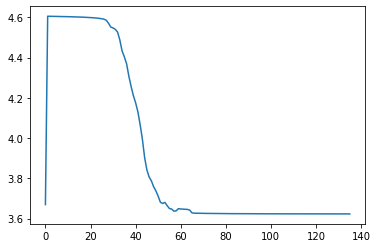

In [270]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(loss_list))
plt.plot(x,loss_list)
plt.show()

In [272]:
corpus[0:20]

input = torch.Tensor([[5]]).long()
tt,h = model.forward(input,None)
print(tt)
print(tt.topk(6))


tensor([[1.6537e-03, 5.0106e-03, 6.9797e-03, 4.6286e-03, 1.9606e-03, 7.5650e-04,
         7.9434e-01, 2.5173e-02, 3.2794e-03, 1.2473e-03, 3.6444e-03, 2.3564e-03,
         5.1677e-03, 1.6386e-03, 3.0004e-03, 1.1903e-03, 1.6400e-03, 4.9065e-03,
         9.4263e-04, 1.6097e-03, 1.2935e-03, 1.3746e-03, 1.2469e-03, 1.4807e-03,
         6.8199e-04, 1.9540e-03, 1.3096e-03, 4.9108e-03, 7.2063e-04, 1.5059e-03,
         2.0091e-03, 2.1672e-03, 2.1353e-03, 9.8396e-04, 3.4713e-03, 1.2766e-03,
         1.5655e-03, 1.3207e-03, 2.6648e-03, 1.5454e-03, 1.2041e-03, 8.7829e-04,
         1.0790e-03, 2.0018e-03, 2.1206e-03, 6.7047e-04, 1.8060e-03, 1.7785e-03,
         1.4840e-03, 1.3894e-03, 1.5312e-03, 1.6352e-03, 1.4807e-03, 1.4497e-03,
         1.6310e-03, 1.5739e-03, 1.5879e-03, 1.4768e-03, 1.5889e-03, 1.2662e-03,
         1.6382e-03, 1.4607e-03, 1.6132e-03, 1.8467e-03, 1.5962e-03, 1.2794e-03,
         1.7894e-03, 1.5789e-03, 1.6658e-03, 1.7412e-03, 1.7732e-03, 1.6717e-03,
         1.3683e-03, 1.4819e

## 保存模型

In [ ]:
path = "/content/drive/MyDrive/ml/nlp/lstm-ptb.pth"

In [ ]:
torch.save(model.state_dict(),path)



## 加载模型

In [ ]:
model.load_state_dict(torch.load(path))

## 测试

In [ ]:
from common.util import most_similar


# ## CBOW 模型的评价

# print(model.inEmbedding.weight.shape)


word_vecs = model.embedding.weight.detach().to(device = "cpu").numpy()

querys = ['you','year','car','toyota']

for query in querys:
  most_similar(query,word_to_id,id_to_word,word_vecs)